In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
result_rcpu = np.loadtxt("result_rpi3.csv", delimiter=',', skiprows=1)
result_ocpu = np.loadtxt("office_cpu.csv", delimiter=',', skiprows=1)
result_ogpu = np.loadtxt("office_gpu.csv", delimiter=',', skiprows=1)
result_jcpu = np.loadtxt("jetson_cpu.csv", delimiter=',', skiprows=1)
cpu_pwr = np.loadtxt("cpu_pwr.log")
result_jgpu = np.loadtxt("jetson_gpu.csv", delimiter=',', skiprows=1)
gpu_pwr = np.loadtxt("gpu_pwr.log")

jcpu_fwd_time = result_jcpu[:, -8].reshape(-1, 3)
jcpu_bwd_time = result_jcpu[:, -7].reshape(-1, 3)
jcpu_mem = result_jcpu[:, -6].reshape(-1, 3)
jgpu_fwd_time = result_jgpu[:, -8].reshape(-1, 3)
jgpu_bwd_time = result_jgpu[:, -7].reshape(-1, 3)
jgpu_mem = result_jgpu[:, -6].reshape(-1, 3)

ocpu_fwd_time = result_ocpu[:, -8].reshape(-1, 3)
ocpu_bwd_time = result_ocpu[:, -7].reshape(-1, 3)
ocpu_mem = result_ocpu[:, -6].reshape(-1, 3)
ogpu_fwd_time = result_ogpu[:, -8].reshape(-1, 3)
ogpu_bwd_time = result_ogpu[:, -7].reshape(-1, 3)
ogpu_mem = result_ogpu[:, -6].reshape(-1, 3)

rcpu_fwd_time = result_rcpu[:, -8].reshape(-1, 3)
rcpu_bwd_time = result_rcpu[:, -7].reshape(-1, 3)
rcpu_mem = result_rcpu[:, -6].reshape(-1, 3)

In [3]:
def get_energy(time_stamp, power):
    duration = (time_stamp[1:] - time_stamp[:-1]) * 1e-6
    avg_power = (power[1:] + power[:-1]) / 2 * 1e-3
    energy = np.sum(duration * avg_power)
    return energy

In [4]:
boundary = 0.05
forward_cpu_energy, backward_cpu_energy = [], []
for test_case in result_jcpu:
    fwd_start, fwd_end, bwd_start, bwd_end = test_case[-4:]
    fwd_start = (1 - boundary) * fwd_start + boundary * fwd_end
    fwd_end = boundary * fwd_start + (1 - boundary) * fwd_end
    bwd_start = (1 - boundary) * bwd_start + boundary * bwd_end
    bwd_end = boundary * bwd_start + (1 - boundary) * bwd_end
    fwd_mask = np.logical_and(cpu_pwr[:, 0] > fwd_start, cpu_pwr[:, 0] < fwd_end)
    bwd_mask = np.logical_and(cpu_pwr[:, 0] > bwd_start, cpu_pwr[:, 0] < bwd_end)
    fwd_pwr, bwd_pwr = cpu_pwr[fwd_mask, :], cpu_pwr[bwd_mask, :]
    fwd_energy = get_energy(fwd_pwr[:, 0], fwd_pwr[:, -1])
    bwd_energy = get_energy(bwd_pwr[:, 0], bwd_pwr[:, -1])
    forward_cpu_energy.append(fwd_energy)
    backward_cpu_energy.append(bwd_energy)
forward_gpu_energy, backward_gpu_energy = [], []
for test_case in result_jgpu:
    fwd_start, fwd_end, bwd_start, bwd_end = test_case[-4:]
    fwd_start = (1 - boundary) * fwd_start + boundary * fwd_end
    fwd_end = boundary * fwd_start + (1 - boundary) * fwd_end
    bwd_start = (1 - boundary) * bwd_start + boundary * bwd_end
    bwd_end = boundary * bwd_start + (1 - boundary) * bwd_end
    fwd_mask = np.logical_and(gpu_pwr[:, 0] > fwd_start, gpu_pwr[:, 0] < fwd_end)
    bwd_mask = np.logical_and(gpu_pwr[:, 0] > bwd_start, gpu_pwr[:, 0] < bwd_end)
    fwd_pwr, bwd_pwr = gpu_pwr[fwd_mask, :], gpu_pwr[bwd_mask, :]
    fwd_energy = get_energy(fwd_pwr[:, 0], fwd_pwr[:, -2])
    bwd_energy = get_energy(bwd_pwr[:, 0], bwd_pwr[:, -2])
    forward_gpu_energy.append(fwd_energy)
    backward_gpu_energy.append(bwd_energy)
forward_cpu_energy = np.array(forward_cpu_energy).reshape(-1, 3)
backward_cpu_energy = np.array(backward_cpu_energy).reshape(-1, 3)
forward_gpu_energy = np.array(forward_gpu_energy).reshape(-1, 3)
backward_gpu_energy = np.array(backward_gpu_energy).reshape(-1, 3)

In [5]:
n = jcpu_fwd_time.shape[0]
jcpu_fwd_overhead = (jcpu_fwd_time[:, 1:] - jcpu_fwd_time[:, 0:1]) / jcpu_fwd_time[:, 0:1]
jcpu_bwd_speedup = jcpu_bwd_time[:, 0:1] / jcpu_bwd_time[:, 1:]
jcpu_mem_saving = jcpu_mem[:, 1:] / jcpu_mem[:, 0:1]
jcpu_energy_saving = backward_cpu_energy[:, 1:] / backward_cpu_energy[:, 0:1]

jgpu_fwd_overhead = (jgpu_fwd_time[:, 1:] - jgpu_fwd_time[:, 0:1]) / jgpu_fwd_time[:, 0:1]
jgpu_bwd_speedup = jgpu_bwd_time[:, 0:1] / jgpu_bwd_time[:, 1:]
jgpu_mem_saving = jgpu_mem[:, 1:] / jgpu_mem[:, 0:1]
jgpu_energy_saving = backward_gpu_energy[:, 1:] / backward_gpu_energy[:, 0:1]

ocpu_fwd_overhead = (ocpu_fwd_time[:, 1:] - ocpu_fwd_time[:, 0:1]) / ocpu_fwd_time[:, 0:1]
ocpu_bwd_speedup = ocpu_bwd_time[:, 0:1] / ocpu_bwd_time[:, 1:]
ocpu_mem_saving = ocpu_mem[:, 1:] / ocpu_mem[:, 0:1]

ogpu_fwd_overhead = (ogpu_fwd_time[:, 1:] - ogpu_fwd_time[:, 0:1]) / ogpu_fwd_time[:, 0:1]
ogpu_bwd_speedup = ogpu_bwd_time[:, 0:1] / ogpu_bwd_time[:, 1:]
ogpu_mem_saving = ogpu_mem[:, 1:] / ogpu_mem[:, 0:1]

rcpu_fwd_overhead = (rcpu_fwd_time[:, 1:] - rcpu_fwd_time[:, 0:1]) / rcpu_fwd_time[:, 0:1]
rcpu_bwd_speedup = rcpu_bwd_time[:, 0:1] / rcpu_bwd_time[:, 1:]
rcpu_mem_saving = rcpu_mem[:, 1:] / rcpu_mem[:, 0:1]

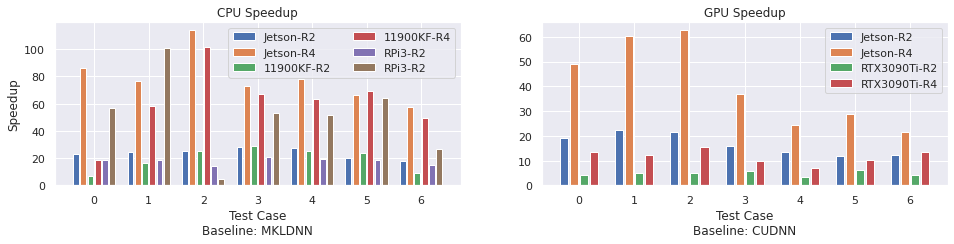

In [6]:
plt.figure(figsize=(16, 3))
plt.subplot(121)
x = np.arange(n) * 7.5
plt.bar(x + 0, jcpu_bwd_speedup[:, 0], label='Jetson-R2')
plt.bar(x + 1, jcpu_bwd_speedup[:, 1], label='Jetson-R4')
plt.bar(x + 2, ocpu_bwd_speedup[:, 0], label='11900KF-R2')
plt.bar(x + 3, ocpu_bwd_speedup[:, 1], label='11900KF-R4')
plt.bar(x + 4, rcpu_bwd_speedup[:, 0], label='RPi3-R2')
plt.bar(x + 5, rcpu_bwd_speedup[:, 1], label='RPi3-R2')
plt.xticks(x + 2.5, np.arange(n))
plt.xlabel("Test Case\nBaseline: MKLDNN")
plt.ylabel("Speedup")
plt.legend(ncol=2)
plt.title("CPU Speedup")

plt.subplot(122)
x = np.arange(n) * 5.5
plt.bar(x + 0, jgpu_bwd_speedup[:, 0], label='Jetson-R2')
plt.bar(x + 1, jgpu_bwd_speedup[:, 1], label='Jetson-R4')
plt.bar(x + 2, ogpu_bwd_speedup[:, 0], label='RTX3090Ti-R2')
plt.bar(x + 3, ogpu_bwd_speedup[:, 1], label='RTX3090Ti-R4')
plt.xticks(x + 1.5, np.arange(n))
plt.xlabel("Test Case\nBaseline: CUDNN")
plt.title("GPU Speedup")
plt.legend()

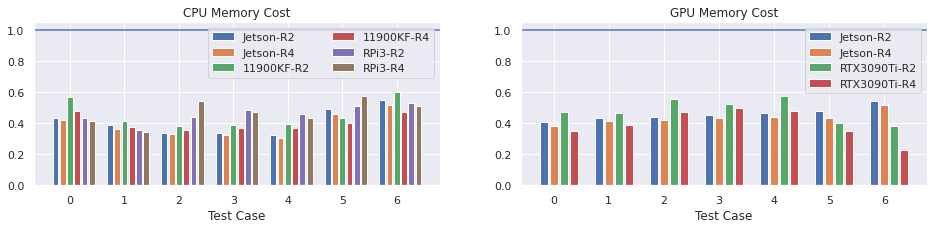

In [7]:
plt.figure(figsize=(16, 3))
plt.subplot(121)
x = np.arange(n) * 7.5
# plt.bar(x, np.ones(n), label='MKLDNN')
plt.axhline(1)
plt.bar(x + 1, jcpu_mem_saving[:, 0], label='Jetson-R2')
plt.bar(x + 2, jcpu_mem_saving[:, 1], label='Jetson-R4')
plt.bar(x + 3, ocpu_mem_saving[:, 0], label='11900KF-R2')
plt.bar(x + 4, ocpu_mem_saving[:, 1], label='11900KF-R4')
plt.bar(x + 5, rcpu_mem_saving[:, 0], label='RPi3-R2')
plt.bar(x + 6, rcpu_mem_saving[:, 1], label='RPi3-R4')
plt.xticks(x + 3, np.arange(n))
plt.xlabel("Test Case")
plt.legend(ncol=2)
plt.title("CPU Memory Cost")

plt.subplot(122)
x = np.arange(n) * 5.5
plt.axhline(1)
# plt.bar(x, np.ones(n), label='CUDNN')
plt.bar(x + 1, jgpu_mem_saving[:, 0], label='Jetson-R2')
plt.bar(x + 2, jgpu_mem_saving[:, 1], label='Jetson-R4')
plt.bar(x + 3, ogpu_mem_saving[:, 0], label='RTX3090Ti-R2')
plt.bar(x + 4, ogpu_mem_saving[:, 1], label='RTX3090Ti-R4')
plt.xticks(x + 2, np.arange(n))
plt.xlabel("Test Case")
plt.title("GPU Memory Cost")
plt.legend()

In [8]:
jcpu_bwd_speedup[:, 1]

array([ 86.04004426,  76.85132249, 114.13771133,  72.9080076 ,
        77.77002007,  66.66681512,  57.30118503])

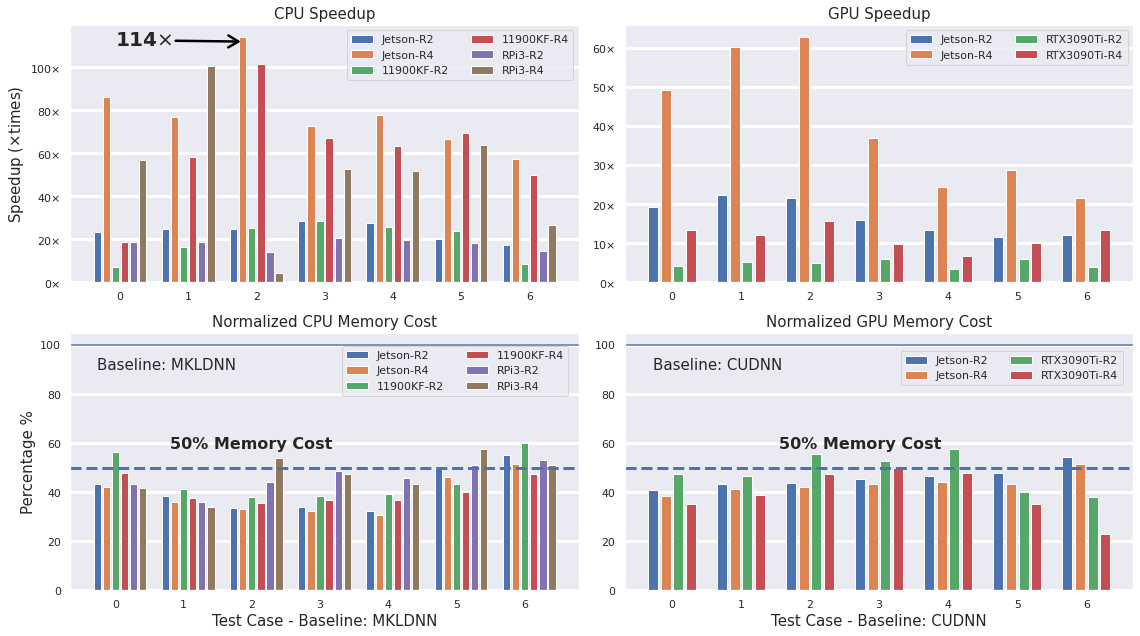

In [13]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
x = np.arange(n) * 7.5
plt.bar(x + 0, jcpu_bwd_speedup[:, 0], label='Jetson-R2')
plt.bar(x + 1, jcpu_bwd_speedup[:, 1], label='Jetson-R4')
plt.bar(x + 2, ocpu_bwd_speedup[:, 0], label='11900KF-R2')
plt.bar(x + 3, ocpu_bwd_speedup[:, 1], label='11900KF-R4')
plt.bar(x + 4, rcpu_bwd_speedup[:, 0], label='RPi3-R2')
plt.bar(x + 5, rcpu_bwd_speedup[:, 1], label='RPi3-R4')
# plt.text(1, 87, "86$\\times$", fontsize=15, ha='center', fontweight='bold')
# plt.text(8.5, 78, f"{jcpu_bwd_speedup[1, 1]:.0f}$\\times$", fontsize=15, ha='center', fontweight='bold')
# plt.text(12.5, rcpu_bwd_speedup[1, 1]+1, f"{rcpu_bwd_speedup[1, 1]:.0f}$\\times$", fontsize=15, ha='center', fontweight='bold')
# plt.text(16, jcpu_bwd_speedup[2, 1]+1, f"{jcpu_bwd_speedup[2, 1]:.0f}$\\times$", fontsize=15, ha='center', fontweight='bold')
# plt.text(23.5, jcpu_bwd_speedup[3, 1]+1, f"{jcpu_bwd_speedup[3, 1]:.0f}$\\times$", fontsize=15, ha='center', fontweight='bold')
arrowprops = dict(arrowstyle="->, head_width=0.3, head_length=0.5", linestyle='-', shrinkA=0, shrinkB=2, linewidth=2.5, color=(0, 0, 0))
plt.annotate("114$\\times$", xy=(16, 112), xytext=(2, 110), arrowprops=arrowprops, fontsize=20, fontweight='bold')
plt.grid(linewidth=3, axis='y')
plt.grid(False, axis='x')
plt.xticks(x + 2.5, np.arange(n))
plt.ylabel("Speedup ($\\times$times)", fontsize=15)
plt.legend(ncol=2, fontsize=11)
plt.yticks(np.arange(0, 101, 20), labels=[f"{s:d}$\\times$" for s in np.arange(0, 101, 20)])
plt.title("CPU Speedup", fontsize=15)

plt.subplot(222)
x = np.arange(n) * 5.5
plt.bar(x + 0, jgpu_bwd_speedup[:, 0], label='Jetson-R2')
plt.bar(x + 1, jgpu_bwd_speedup[:, 1], label='Jetson-R4')
plt.bar(x + 2, ogpu_bwd_speedup[:, 0], label='RTX3090Ti-R2')
plt.bar(x + 3, ogpu_bwd_speedup[:, 1], label='RTX3090Ti-R4')
plt.xticks(x + 1.5, np.arange(n))
plt.yticks(np.arange(0, 61, 10), labels=[f"{s:d}$\\times$" for s in np.arange(0, 61, 10)])
# plt.text(1, jgpu_bwd_speedup[0, 1] + 1, f"{jgpu_bwd_speedup[0, 1]:.0f}$\\times$", fontsize=15, fontweight='bold', ha='center')
# plt.text(6.5, jgpu_bwd_speedup[1, 1] + 1, f"{jgpu_bwd_speedup[1, 1]:.0f}$\\times$", fontsize=15, fontweight='bold', ha='center')
# plt.text(12, jgpu_bwd_speedup[2, 1] + 1, f"{jgpu_bwd_speedup[2, 1]:.0f}$\\times$", fontsize=15, fontweight='bold', ha='center')
# plt.text(17.5, jgpu_bwd_speedup[3, 1] + 1, f"{jgpu_bwd_speedup[3, 1]:.0f}$\\times$", fontsize=15, fontweight='bold', ha='center')
plt.grid(linewidth=3)
plt.grid(False, axis='x')
plt.title("GPU Speedup", fontsize=15)
plt.legend(ncol=2, fontsize=11)

plt.subplot(223)
x = np.arange(n) * 7.5
# plt.bar(x, np.ones(n), label='MKLDNN')
plt.axhline(100)
plt.bar(x + 0, jcpu_mem_saving[:, 0] * 100, label='Jetson-R2')
plt.bar(x + 1, jcpu_mem_saving[:, 1] * 100, label='Jetson-R4')
plt.bar(x + 2, ocpu_mem_saving[:, 0] * 100, label='11900KF-R2')
plt.bar(x + 3, ocpu_mem_saving[:, 1] * 100, label='11900KF-R4')
plt.bar(x + 4, rcpu_mem_saving[:, 0] * 100, label='RPi3-R2')
plt.bar(x + 5, rcpu_mem_saving[:, 1] * 100, label='RPi3-R4')
plt.text(0, 90, "Baseline: MKLDNN", fontsize=15)
plt.xticks(x + 2, np.arange(n))
plt.axhline(50, linewidth=3, linestyle='--')
plt.text(8, 58, "50% Memory Cost", fontsize=16, fontweight='bold')
plt.grid(linewidth=3)
plt.grid(False, axis='x')
plt.xlabel("Test Case - Baseline: MKLDNN", fontsize=15)
plt.ylabel("Percentage %", fontsize=15)
plt.legend(ncol=2, loc=0, bbox_to_anchor=(0.99, 0.97), fontsize=11)
plt.title("Normalized CPU Memory Cost", fontsize=15)

plt.subplot(224)
x = np.arange(n) * 5.5
plt.axhline(100)
# plt.bar(x, np.ones(n), label='CUDNN')
plt.bar(x + 0, jgpu_mem_saving[:, 0] * 100, label='Jetson-R2')
plt.bar(x + 1, jgpu_mem_saving[:, 1] * 100, label='Jetson-R4')
plt.bar(x + 2, ogpu_mem_saving[:, 0] * 100, label='RTX3090Ti-R2')
plt.bar(x + 3, ogpu_mem_saving[:, 1] * 100, label='RTX3090Ti-R4')
plt.text(0, 90, "Baseline: CUDNN", fontsize=15)
plt.xticks(x + 1.5, np.arange(n))
plt.axhline(50, linewidth=3, linestyle='--')
plt.text(10, 58, "50% Memory Cost", fontsize=16, fontweight='bold')
plt.grid(linewidth=3)
plt.grid(False, axis='x')
plt.xlabel("Test Case - Baseline: CUDNN", fontsize=15)
plt.title("Normalized GPU Memory Cost", fontsize=15)
plt.legend(ncol=2, bbox_to_anchor=(0.99, 0.95), fontsize=11)
plt.tight_layout()
# plt.subplots_adjust(top=0.95, bottom=0.09, hspace=0.25, wspace=0.1)
plt.savefig("speedup_mem.pdf")

In [11]:
jcpu_mem_saving[2, 1]

0.3333081212291781

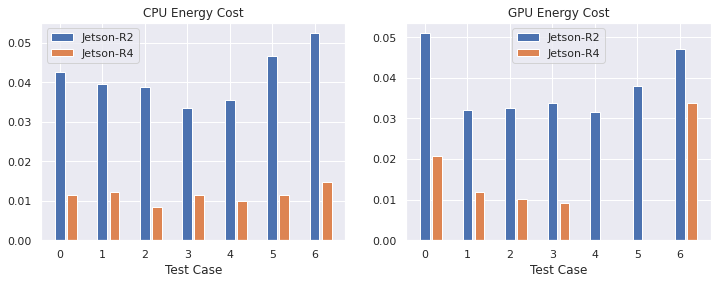

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
x = np.arange(n) * 3.5
plt.bar(x + 1, jcpu_energy_saving[:, 0], label='Jetson-R2')
plt.bar(x + 2, jcpu_energy_saving[:, 1], label='Jetson-R4')
plt.xticks(x + 1, np.arange(n))
plt.xlabel("Test Case")
plt.legend()
plt.title("CPU Energy Cost")

plt.subplot(122)
x = np.arange(n) * 3.5
plt.bar(x + 1, jgpu_energy_saving[:, 0], label='Jetson-R2')
plt.bar(x + 2, jgpu_energy_saving[:, 1], label='Jetson-R4')
plt.xticks(x + 1, np.arange(n))
plt.xlabel("Test Case")
plt.title("GPU Energy Cost")
plt.legend()

In [13]:
np.mean(jcpu_energy_saving, axis=0), np.std(jcpu_energy_saving, axis=0), np.mean(jgpu_energy_saving, axis=0), np.std(jgpu_energy_saving, axis=0)

(array([0.04128021, 0.01146039]),
 array([0.00605271, 0.00179356]),
 array([0.03803515, 0.0122462 ]),
 array([0.00729063, 0.01099547]))

Text(0.5, 1.0, 'GPU Overhead')

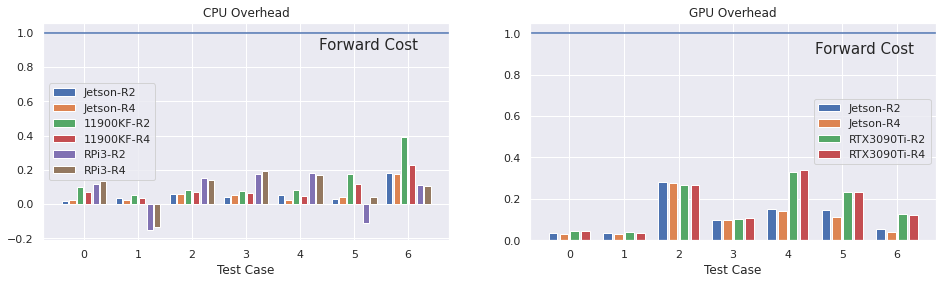

In [9]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
x = np.arange(n) * 7
plt.bar(x + 0, jcpu_fwd_overhead[:, 0], label="Jetson-R2")
plt.bar(x + 1, jcpu_fwd_overhead[:, 1], label="Jetson-R4")
plt.bar(x + 2, ocpu_fwd_overhead[:, 0], label="11900KF-R2")
plt.bar(x + 3, ocpu_fwd_overhead[:, 1], label="11900KF-R4")
plt.bar(x + 4, rcpu_fwd_overhead[:, 0], label="RPi3-R2")
plt.bar(x + 5, rcpu_fwd_overhead[:, 1], label="RPi3-R4")
plt.axhline(1.0)
plt.text(33, 0.9, "Forward Cost", fontsize=15)
plt.xticks(x + 2.5, np.arange(n))
plt.xlabel("Test Case")
plt.legend()
plt.title("CPU Overhead")

plt.subplot(122)
x = np.arange(n) * 5
plt.bar(x + 0, jgpu_fwd_overhead[:, 0], label="Jetson-R2")
plt.bar(x + 1, jgpu_fwd_overhead[:, 1], label="Jetson-R4")
plt.bar(x + 2, ogpu_fwd_overhead[:, 0], label="RTX3090Ti-R2")
plt.bar(x + 3, ogpu_fwd_overhead[:, 1], label="RTX3090Ti-R4")
plt.axhline(1.0)
plt.text(24, 0.9, "Forward Cost", fontsize=15)
plt.xticks(x + 1.5, np.arange(n))
plt.xlabel("Test Case")
plt.legend()
plt.title("GPU Overhead")